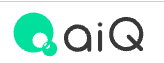

[disclaimer](../../disclaimer.txt/)

# ALTERNATIVE DATA Evaluation Demo

## Evaluate aiQ POS Csmr Goods using aiQ Lab Alt Data Evaluation Tool

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import numpy as np
import pandas as pd
import plotly.io

for_html = False
if for_html:
    plotly.offline.init_notebook_mode()
else:
    plotly.io.renderers.default = 'iframe'

sys.path.append('../..')
from utils.shortcut import single_dataset as sc


## データロード

### データハンドラーのインポート

In [3]:
from aiq_strategy_robot.data.data_accessor import DAL

### データロード
当該サンプルではデータファイルのサンプルを使用して以降の説明を行います.<br>
実際のデータロードを行いながらサンプルを実行したい場合、`load_sample_dataset`メソッドの`data_dir`を指定せずに実行してください.

```
# データソースからロード
sc.load_sample_dataset(sdh, start_date='2015-09-30', end_date='2024-06-01')
```

なお、データファイル（サンプルデフォルト）のデータソースは<br>

    - market:      finnhub
    - fundamental: finnhub
    - alternative: aiQ csmr Goods

データローダーによるデータソースは<br>

    - market:      finnhub
    - fundamental: finnhub
    - alternative: aiQ csmr Goods

となります.


In [4]:
sdh = DAL()

# ファイルデータからハンドラーに登録
sc.load_sample_dataset(sdh, data_dir=sc.DEFAULT_DIR)
# sc.load_sample_dataset(sdh, start_date='2015-09-30', end_date='2024-06-01')

display(sdh.extract_definition)

data_id_alt = 1
data_id_funda = 2
data_id_mkt = 3

category data_source  source    table               alias  \
data_id                                                             
1        RawData    external  sample  Unknown  aiq_pos_csmr_goods   
2        RawData    external  sample  Unknown               sales   
3        RawData    external  sample  Unknown              market   

                                                   tickers  \
data_id                                                      
1        [1301-JP, 1332-JP, 1333-JP, 1379-JP, 1380-JP, ...   
2        [1301-JP, 1332-JP, 1333-JP, 1379-JP, 1380-JP, ...   
3        [1301-JP, 1332-JP, 1333-JP, 1379-JP, 1380-JP, ...   

                      index       start_datetime         end_datetime  
data_id                                                                
1        [ticker, datetime]  2008-03-16 00:00:00  2024-03-03 00:00:00  
2        [ticker, datetime]  2008-03-31 00:00:00  2024-01-31 00:00:00  
3        [ticker, datetime]  2008-03-14 00:00:00  2024-03-22 00:00:00

In [5]:
dfmkt = sdh.get_raw_data(data_id_mkt)
sample_target = "2281-JP" if "2281-JP" in sdh.extract_definition.loc[data_id_mkt].tickers else "2281 JP"
funda_field = sdh.extract_definition.loc[data_id_funda].alias
funda_field

'sales'

## 相関計算

### `AltDataEvaluator`作成
セットアップしたデータハンドラーを渡し`AltDataEvaluator`を作成

In [6]:
from aiq_strategy_robot.evaluator import AltDataEvaluator

# Initialize AltDataEvaluator
ade = AltDataEvaluator(sdh)

### 四半期売上高との相関を計算

In [7]:
features = sdh.get_raw_data(data_id_alt).columns
features

Index(['pos_sales', 'share', 'unit_price', 'unit_price_vs_ind'], dtype='object')

In [8]:
sdh.transform.clear()
funda_Q_ids = sdh.transform.resample(data_id=data_id_funda, fields=funda_field, rule='Q', func='last').variable_ids
alt_Q_ids = sdh.transform.resample(data_id=data_id_alt, rule='Q', func='mean').variable_ids

#### 四半期売上高とのプロット

四半期売上高とオルタナティブデータをプロットします.

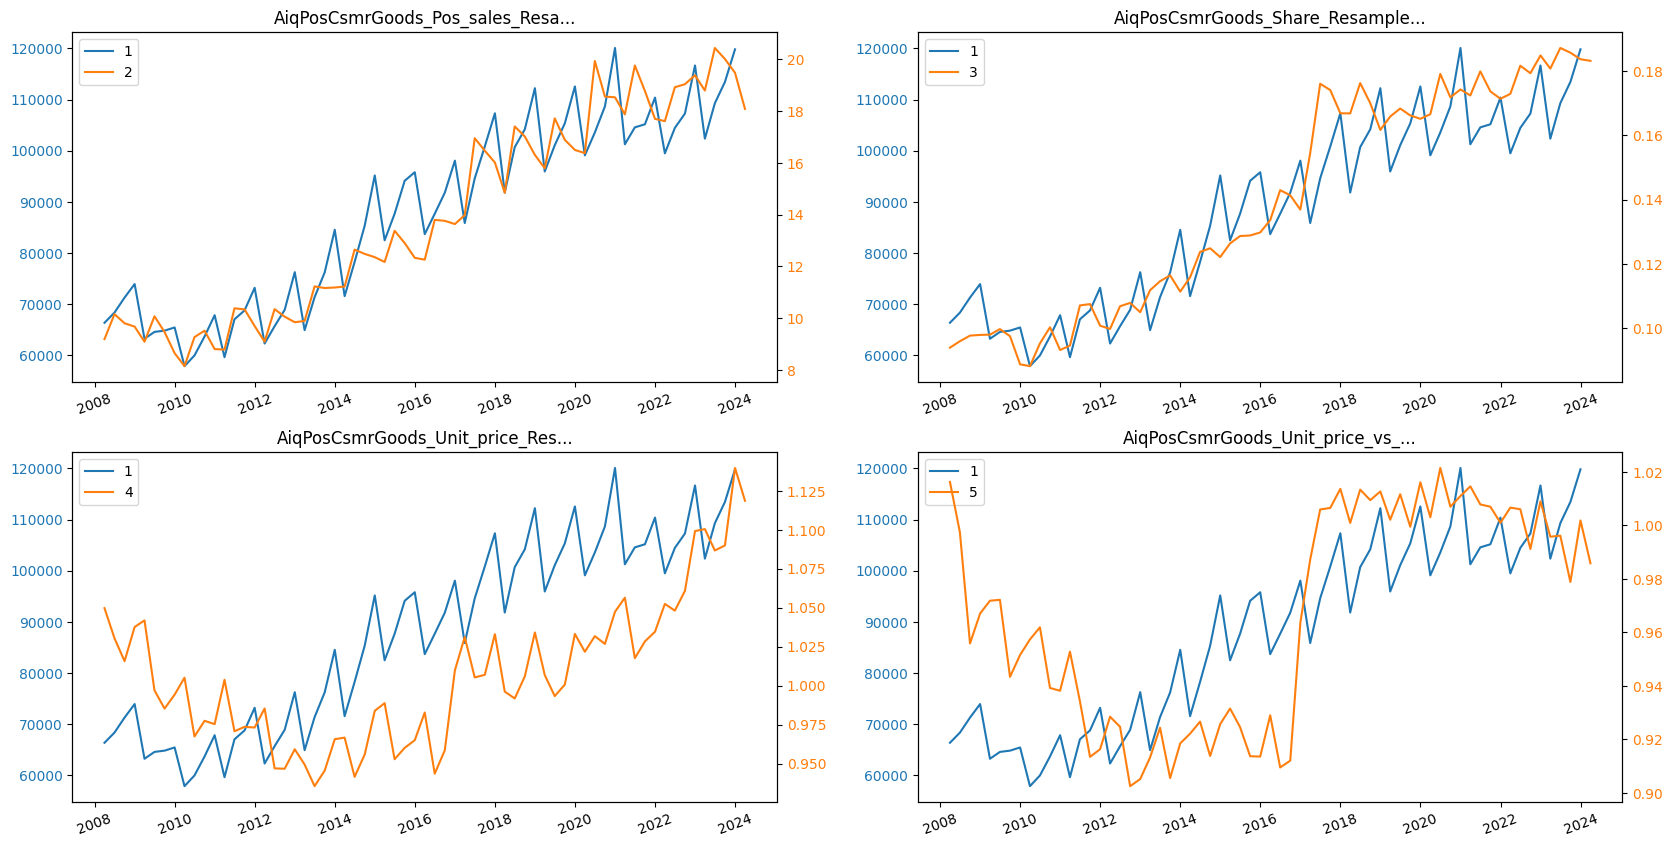

In [9]:
sdh.show_line_one_target(
    target=sample_target, #どの ticker のデータを描画するかを決めます
    y=funda_Q_ids[0], #y軸に表示するデータを variable_id で指定します
    X= alt_Q_ids, #x軸に表示するデータを variable_id の list で指定します（複数のグラフを一気に表示する時に list にします）
    col_num=2, #1行にいくつのグラフを表示するかを決めます
    vname_len_limit=30, #タイトルにXのvariable_id の変数名が表示されますが、表示を短くするために文字数を指定します
)

> データの時系列をshiftし、売上高とのプロットがどのように変化するかを見ます.

In [10]:
alt_Q_shift_1_ids = sdh.transform.shift(data_id=data_id_alt, periods=1).resample(rule='Q', func='mean').variable_ids
alt_Q_shift_2_ids = sdh.transform.shift(data_id=data_id_alt, periods=2).resample(rule='Q', func='mean').variable_ids
alt_Q_shift_3_ids = sdh.transform.shift(data_id=data_id_alt, periods=3).resample(rule='Q', func='mean').variable_ids
alt_Q_shift_4_ids = sdh.transform.shift(data_id=data_id_alt, periods=4).resample(rule='Q', func='mean').variable_ids

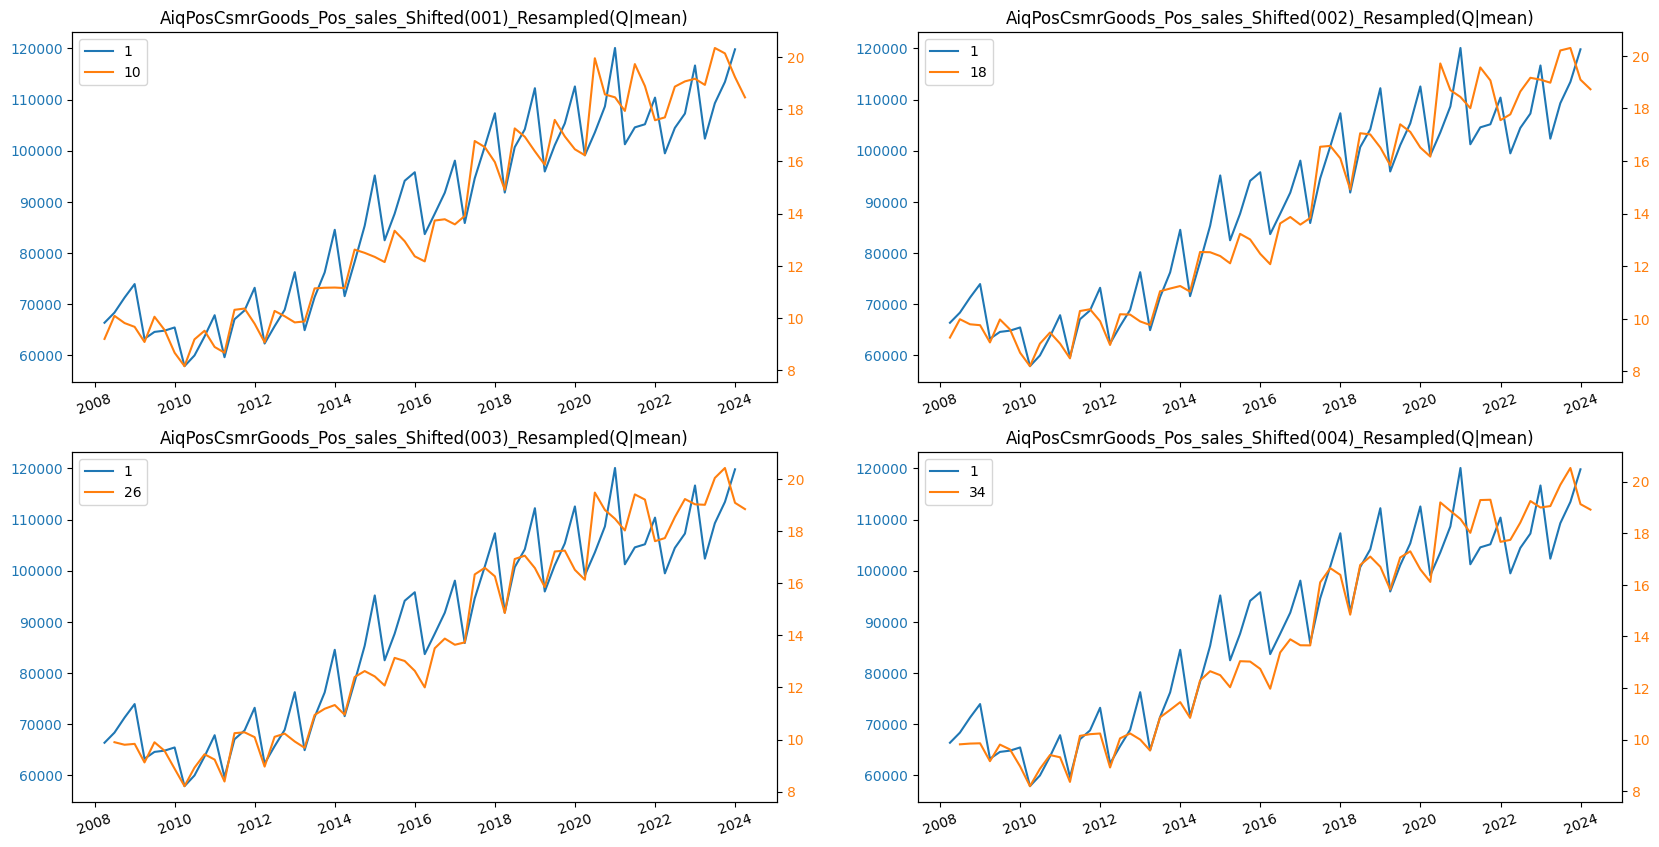

In [11]:
# View Sales vs Pos Sales
sdh.show_line_one_target(
    target=sample_target,
    y=funda_Q_ids[0],
    X=[alt_Q_shift_1_ids[0], alt_Q_shift_2_ids[0], 
       alt_Q_shift_3_ids[0], alt_Q_shift_4_ids[0]],
    col_num=2
)

> 特徴量を対数変換して相関計算を行います

In [12]:
sales_id = sdh.transform.log_diff(fields=funda_Q_ids, periods=4).diff(periods=1).variable_ids[-1]
alt_Q_shift_0_logdiff_ids = sdh.transform.log_diff(fields=alt_Q_ids, periods=4).variable_ids
alt_Q_shift_1_logdiff_ids = sdh.transform.log_diff(fields=alt_Q_shift_1_ids, periods=4).diff(periods=1).variable_ids
alt_Q_shift_2_logdiff_ids = sdh.transform.log_diff(fields=alt_Q_shift_2_ids, periods=4).diff(periods=1).variable_ids
alt_Q_shift_3_logdiff_ids = sdh.transform.log_diff(fields=alt_Q_shift_3_ids, periods=4).diff(periods=1).variable_ids
alt_Q_shift_4_logdiff_ids = sdh.transform.log_diff(fields=alt_Q_shift_4_ids, periods=4).diff(periods=1).variable_ids

# Check application of method chain.
sdh.transform.show_method_chain()

data_id      variable_ids  \
process_id                              
12                2              [39]   
13                1  [40, 41, 42, 43]   
15                1  [48, 49, 50, 51]   
17                1  [56, 57, 58, 59]   
19                1  [64, 65, 66, 67]   
21                1  [72, 73, 74, 75]   

                                                           root  \
process_id                                                        
12          resample(rule="Q", func="last", origin="start_day")   
13          resample(rule="Q", func="mean", origin="start_day")   
15                                             shift(periods=1)   
17                                             shift(periods=2)   
19                                             shift(periods=3)   
21                                             shift(periods=4)   

                                                       step_001  \
process_id                                                        
12                                          log_diff(periods=4)   
13                                          log_diff(periods=4)   
15          resample(rule="Q", func="mean", origin="start_day")   
17          resample(rule="Q", func="mean", origin="start_day")   
19          resample(rule="Q", func="mean", origin="start_day")   
21          resample(rule="Q", func="mean", origin="start_day")   

                       step_002         step_003  
process_id                                        
12              diff(periods=1)                -  
13                            -                -  
15          log_diff(periods=4)  diff(periods=1)  
17          log_diff(periods=4)  diff(periods=1)  
19          log_diff(periods=4)  diff(periods=1)  
21          log_diff(periods=4)  diff(periods=1)

##### Calculation of correlations.

In [13]:
rho_pool = pd.DataFrame()
rho_pool['n_shift=0'] = ade.compu_rho(alt_Q_shift_0_logdiff_ids, sales_id, rename_features=features)
rho_pool['n_shift=1'] = ade.compu_rho(alt_Q_shift_1_logdiff_ids, sales_id, rename_features=features)
rho_pool['n_shift=2'] = ade.compu_rho(alt_Q_shift_2_logdiff_ids, sales_id, rename_features=features)
rho_pool['n_shift=3'] = ade.compu_rho(alt_Q_shift_3_logdiff_ids, sales_id, rename_features=features)
rho_pool['n_shift=4'] = ade.compu_rho(alt_Q_shift_4_logdiff_ids, sales_id, rename_features=features)
display(rho_pool.xs('t-val', level=1).sort_values(rho_pool.columns[0], ascending=False))

n_shift=0  n_shift=1  n_shift=2  n_shift=3  n_shift=4
pos_sales           5.172258  11.830420   8.804926   6.494567   5.047130
share               0.988347   5.745472   4.649866   3.393505   3.513294
unit_price_vs_ind  -1.047745   0.161389  -0.083414  -0.240519  -0.183557
unit_price         -2.473243  -0.919916  -1.247396  -1.654100  -1.577578

> もっとも相関の良いN件のTickerを選びます

In [14]:
rho_time = ade.compu_rho(alt_Q_shift_1_logdiff_ids, sales_id, by='ticker', rename_features=features)
rho_time.T.xs('t-val', level=1).sort_values('pos_sales', ascending=False).head()

pos_sales     share  unit_price  unit_price_vs_ind
ticker                                                     
4452-JP   6.804325  2.962737    5.458577           2.882926
2220-JP   6.744614  4.253203   -0.227348          -0.725660
2919-JP   6.020033 -0.168539    1.869244           2.445909
2221-JP   6.003516  3.729421   -0.728411           0.431869
2804-JP   5.904020  0.288348    1.136534          -2.211117

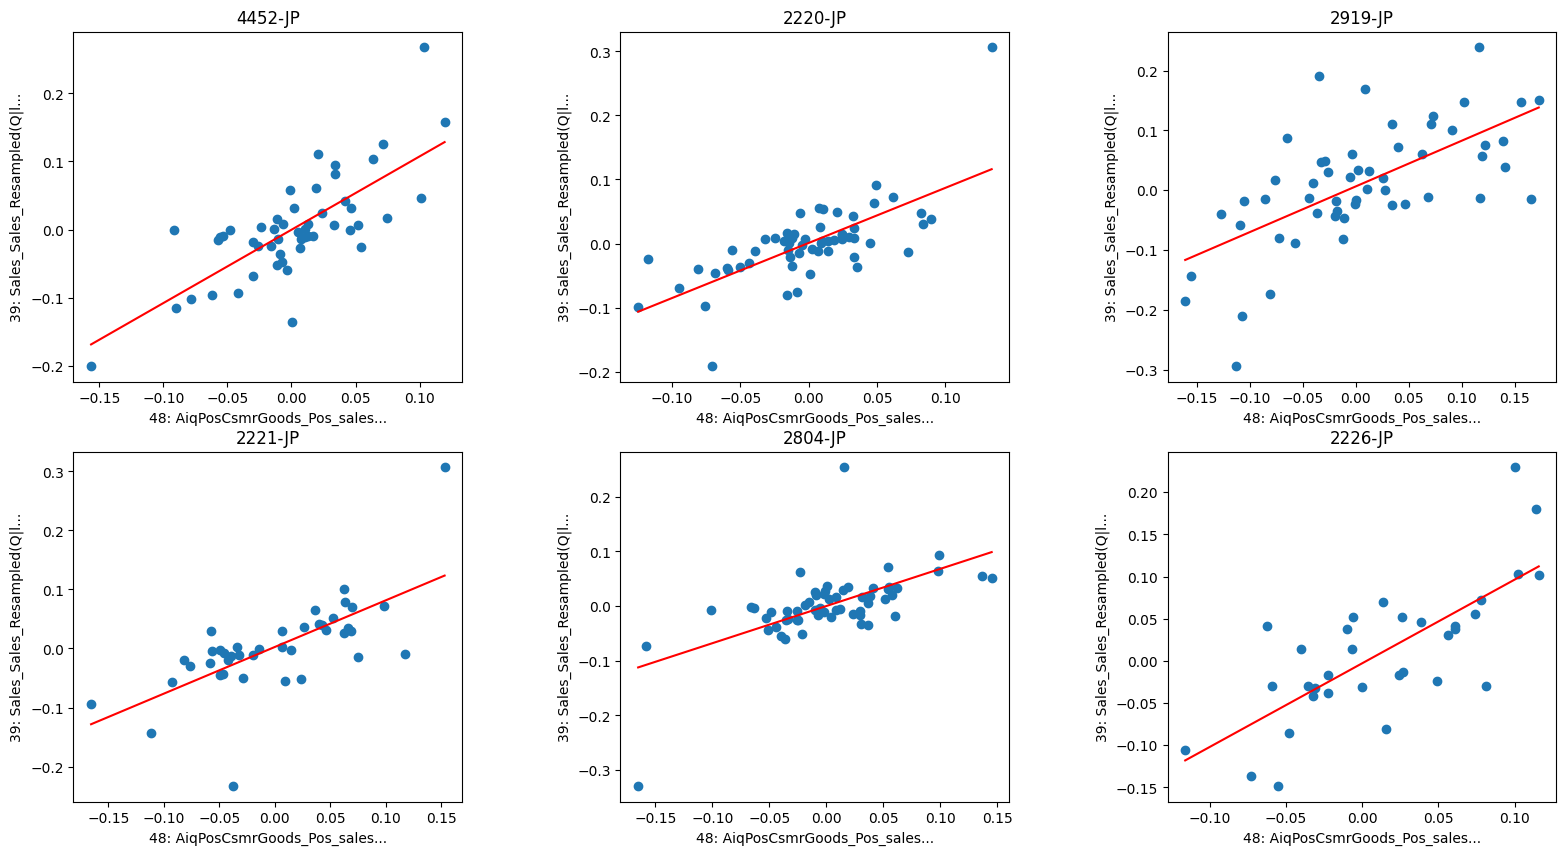

In [15]:
top6tickers = rho_time.T.xs('t-val', level=1).sort_values('pos_sales', ascending=False).index[:6]

sdh.show_scatter_per_target(
    y=sales_id,
    x=alt_Q_shift_1_logdiff_ids[0],
    targets=top6tickers,
    col_num=3,
    vname_len_limit=25,
)

### 株価変化率との相関

週次データにリサンプルしてKPIをオルタナティブデータの相関を分析します.

In [16]:
mkt_W_close_id = sdh.transform.resample(data_id=data_id_mkt, rule='W', fields='close', func='last').variable_ids[-1]
alt_W_ids = sdh.transform.resample(data_id=data_id_alt, rule='W', func='mean').variable_ids

#### 株価変化率とのプロット
株価変化率高とオルタナティブデータをプロットします.

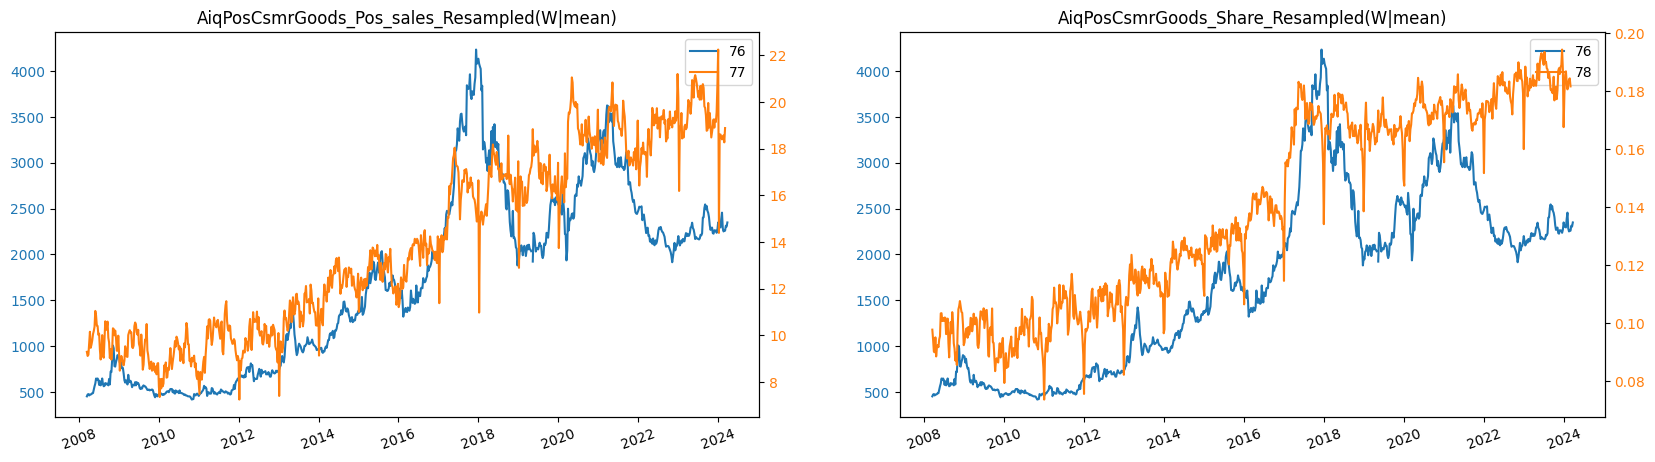

In [17]:
sdh.show_line_one_target(
    target=sample_target,
    y=mkt_W_close_id,
    X=alt_W_ids[:2],
    col_num=2
)

In [18]:
alt_W_shift_0_ids = sdh.transform.sma(fields=alt_W_ids, periods=12).variable_ids
alt_W_shift_1_ids = sdh.transform.shift(data_id=data_id_alt, periods=1).resample(rule='W', func='mean').sma(periods=12).variable_ids
alt_W_shift_2_ids = sdh.transform.shift(data_id=data_id_alt, periods=2).resample(rule='W', func='mean').sma(periods=12).variable_ids
alt_W_shift_3_ids = sdh.transform.shift(data_id=data_id_alt, periods=3).resample(rule='W', func='mean').sma(periods=12).variable_ids
alt_W_shift_4_ids = sdh.transform.shift(data_id=data_id_alt, periods=4).resample(rule='W', func='mean').sma(periods=12).variable_ids
alt_W_shift_5_ids = sdh.transform.shift(data_id=data_id_alt, periods=5).resample(rule='W', func='mean').sma(periods=12).variable_ids
alt_W_shift_6_ids = sdh.transform.shift(data_id=data_id_alt, periods=6).resample(rule='W', func='mean').sma(periods=12).variable_ids
alt_W_shift_7_ids = sdh.transform.shift(data_id=data_id_alt, periods=7).resample(rule='W', func='mean').sma(periods=12).variable_ids
alt_W_shift_8_ids = sdh.transform.shift(data_id=data_id_alt, periods=8).resample(rule='W', func='mean').sma(periods=12).variable_ids

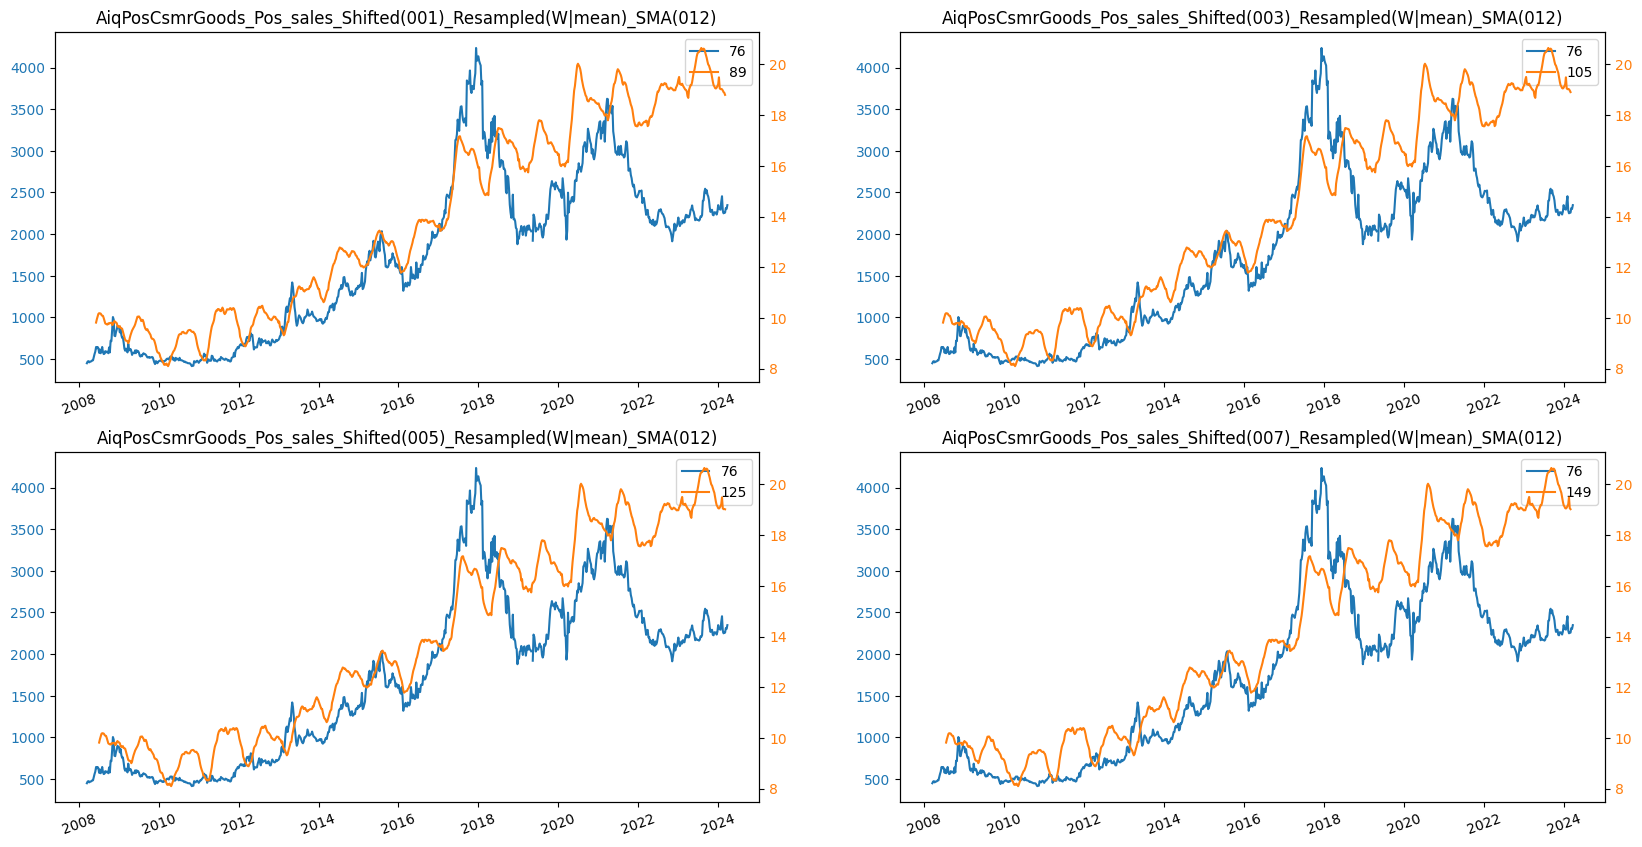

In [19]:
# View Sales vs Pos Sales
sdh.show_line_one_target(
    target=sample_target,
    y=mkt_W_close_id,
    X=[alt_W_shift_1_ids[0], alt_W_shift_3_ids[0], 
       alt_W_shift_5_ids[0], alt_W_shift_7_ids[0]],
    col_num=2
)

> 特徴量を対数変換して相関計算を行います

In [20]:
alt_W_shift_0_sma12_logdiff_ids = sdh.transform.log_diff(fields=alt_W_shift_0_ids, periods=52).variable_ids
alt_W_shift_1_sma12_logdiff_ids = sdh.transform.log_diff(fields=alt_W_shift_1_ids, periods=52).variable_ids
alt_W_shift_2_sma12_logdiff_ids = sdh.transform.log_diff(fields=alt_W_shift_2_ids, periods=52).variable_ids
alt_W_shift_3_sma12_logdiff_ids = sdh.transform.log_diff(fields=alt_W_shift_3_ids, periods=52).variable_ids
alt_W_shift_4_sma12_logdiff_ids = sdh.transform.log_diff(fields=alt_W_shift_4_ids, periods=52).variable_ids
alt_W_shift_5_sma12_logdiff_ids = sdh.transform.log_diff(fields=alt_W_shift_5_ids, periods=52).variable_ids
alt_W_shift_6_sma12_logdiff_ids = sdh.transform.log_diff(fields=alt_W_shift_6_ids, periods=52).variable_ids
alt_W_shift_7_sma12_logdiff_ids = sdh.transform.log_diff(fields=alt_W_shift_7_ids, periods=52).variable_ids
alt_W_shift_8_sma12_logdiff_ids = sdh.transform.log_diff(fields=alt_W_shift_8_ids, periods=52).variable_ids

close_ret = sdh.transform.dropna(fields=mkt_W_close_id, how='all').log_diff(periods=1, names='ret').variable_ids[-1]

funda_Q_ids# メソッドチェーンを確認
sdh.transform.show_method_chain()

data_id          variable_ids  \
process_id                                  
12                2                  [39]   
13                1      [40, 41, 42, 43]   
15                1      [48, 49, 50, 51]   
17                1      [56, 57, 58, 59]   
19                1      [64, 65, 66, 67]   
21                1      [72, 73, 74, 75]   
45                1  [165, 166, 167, 168]   
46                1  [169, 170, 171, 172]   
47                1  [173, 174, 175, 176]   
48                1  [177, 178, 179, 180]   
49                1  [181, 182, 183, 184]   
50                1  [185, 186, 187, 188]   
51                1  [189, 190, 191, 192]   
52                1  [193, 194, 195, 196]   
53                1  [197, 198, 199, 200]   
55                3                 [202]   

                                                           root  \
process_id                                                        
12          resample(rule="Q", func="last", origin="start_day")   
13          resample(rule="Q", func="mean", origin="start_day")   
15                                             shift(periods=1)   
17                                             shift(periods=2)   
19                                             shift(periods=3)   
21                                             shift(periods=4)   
45          resample(rule="W", func="mean", origin="start_day")   
46                                             shift(periods=1)   
47                                             shift(periods=2)   
48                                             shift(periods=3)   
49                                             shift(periods=4)   
50                                             shift(periods=5)   
51                                             shift(periods=6)   
52                                             shift(periods=7)   
53                                             shift(periods=8)   
55          resample(rule="W", func="last", origin="start_day")   

                                                       step_001  \
process_id                                                        
12                                          log_diff(periods=4)   
13                                          log_diff(periods=4)   
15          resample(rule="Q", func="mean", origin="start_day")   
17          resample(rule="Q", func="mean", origin="start_day")   
19          resample(rule="Q", func="mean", origin="start_day")   
21          resample(rule="Q", func="mean", origin="start_day")   
45                                              sma(periods=12)   
46          resample(rule="W", func="mean", origin="start_day")   
47          resample(rule="W", func="mean", origin="start_day")   
48          resample(rule="W", func="mean", origin="start_day")   
49          resample(rule="W", func="mean", origin="start_day")   
50          resample(rule="W", func="mean", origin="start_day")   
51          resample(rule="W", func="mean", origin="start_day")   
52          resample(rule="W", func="mean", origin="start_day")   
53          resample(rule="W", func="mean", origin="start_day")   
55                                            dropna(how="all")   

                        step_002              step_003  
process_id                                              
12               diff(periods=1)                     -  
13                             -                     -  
15           log_diff(periods=4)       diff(periods=1)  
17           log_diff(periods=4)       diff(periods=1)  
19           log_diff(periods=4)       diff(periods=1)  
21           log_diff(periods=4)       diff(periods=1)  
45          log_diff(periods=52)                     -  
46               sma(periods=12)  log_diff(periods=52)  
47               sma(periods=12)  log_diff(periods=52)  
48               sma(periods=12)  log_diff(periods=52)  
49               sma(periods=12)  log_diff(periods=52)  
50               sma(periods=12)  log_diff(per

Calculation

In [21]:
rho_pool = pd.DataFrame()
rho_pool['n_shift=0, sma=12, diff1'] = ade.compu_rho(alt_W_shift_0_sma12_logdiff_ids, close_ret, rename_features=features)
rho_pool['n_shift=1, sma=12, diff1'] = ade.compu_rho(alt_W_shift_1_sma12_logdiff_ids, close_ret, rename_features=features)
rho_pool['n_shift=2, sma=12, diff1'] = ade.compu_rho(alt_W_shift_2_sma12_logdiff_ids, close_ret, rename_features=features)
rho_pool['n_shift=3, sma=12, diff1'] = ade.compu_rho(alt_W_shift_3_sma12_logdiff_ids, close_ret, rename_features=features)
rho_pool['n_shift=4, sma=12, diff1'] = ade.compu_rho(alt_W_shift_4_sma12_logdiff_ids, close_ret, rename_features=features)
rho_pool['n_shift=5, sma=12, diff1'] = ade.compu_rho(alt_W_shift_5_sma12_logdiff_ids, close_ret, rename_features=features)
rho_pool['n_shift=6, sma=12, diff1'] = ade.compu_rho(alt_W_shift_6_sma12_logdiff_ids, close_ret, rename_features=features)
rho_pool['n_shift=7, sma=12, diff1'] = ade.compu_rho(alt_W_shift_7_sma12_logdiff_ids, close_ret, rename_features=features)
rho_pool['n_shift=8, sma=12, diff1'] = ade.compu_rho(alt_W_shift_8_sma12_logdiff_ids, close_ret, rename_features=features)

display(rho_pool.xs('t-val', level=1).sort_values(rho_pool.columns[0], ascending=False))

n_shift=0, sma=12, diff1  n_shift=1, sma=12, diff1  \
pos_sales                          6.455726                  6.558211   
share                              3.674076                  3.512375   
unit_price                         0.908143                  0.857340   
unit_price_vs_ind                 -1.115234                 -1.393382   

                   n_shift=2, sma=12, diff1  n_shift=3, sma=12, diff1  \
pos_sales                          6.288663                  6.414349   
share                              3.308825                  3.092316   
unit_price                         1.055606                  1.200542   
unit_price_vs_ind                 -1.286122                 -1.087548   

                   n_shift=4, sma=12, diff1  n_shift=5, sma=12, diff1  \
pos_sales                          6.387721                  6.118143   
share                              3.389276                  3.285500   
unit_price                         1.098926                  1.213180   
unit_price_vs_ind                 -1.090011                 -1.084866   

                   n_shift=6, sma=12, diff1  n_shift=7, sma=12, diff1  \
pos_sales                          5.487600                  5.382758   
share                              3.120749                  3.122486   
unit_price                         1.053002                  0.869211   
unit_price_vs_ind                 -1.408818                 -1.514960   

                   n_shift=8, sma=12, diff1  
pos_sales                          4.938323  
share                              3.040014  
unit_price                         0.516296  
unit_price_vs_ind                 -1.700693

> もっとも相関の良いN件のTickerを選びます

In [22]:
rho_time = ade.compu_rho(alt_W_shift_1_sma12_logdiff_ids, close_ret, by='ticker', rename_features=features)
rho_time.T.xs('t-val', level=1).sort_values('pos_sales', ascending=False).head()

pos_sales     share  unit_price  unit_price_vs_ind
ticker                                                     
2281-JP   3.505645  3.369123    2.137623           1.162140
5194-JP   3.188901  3.761244    2.029955           1.704698
2212-JP   3.056784  1.782047    1.017993          -0.322797
2884-JP   2.914284  1.194342    0.175939           1.497298
2266-JP   2.466982  0.240809   -1.466657          -0.826028

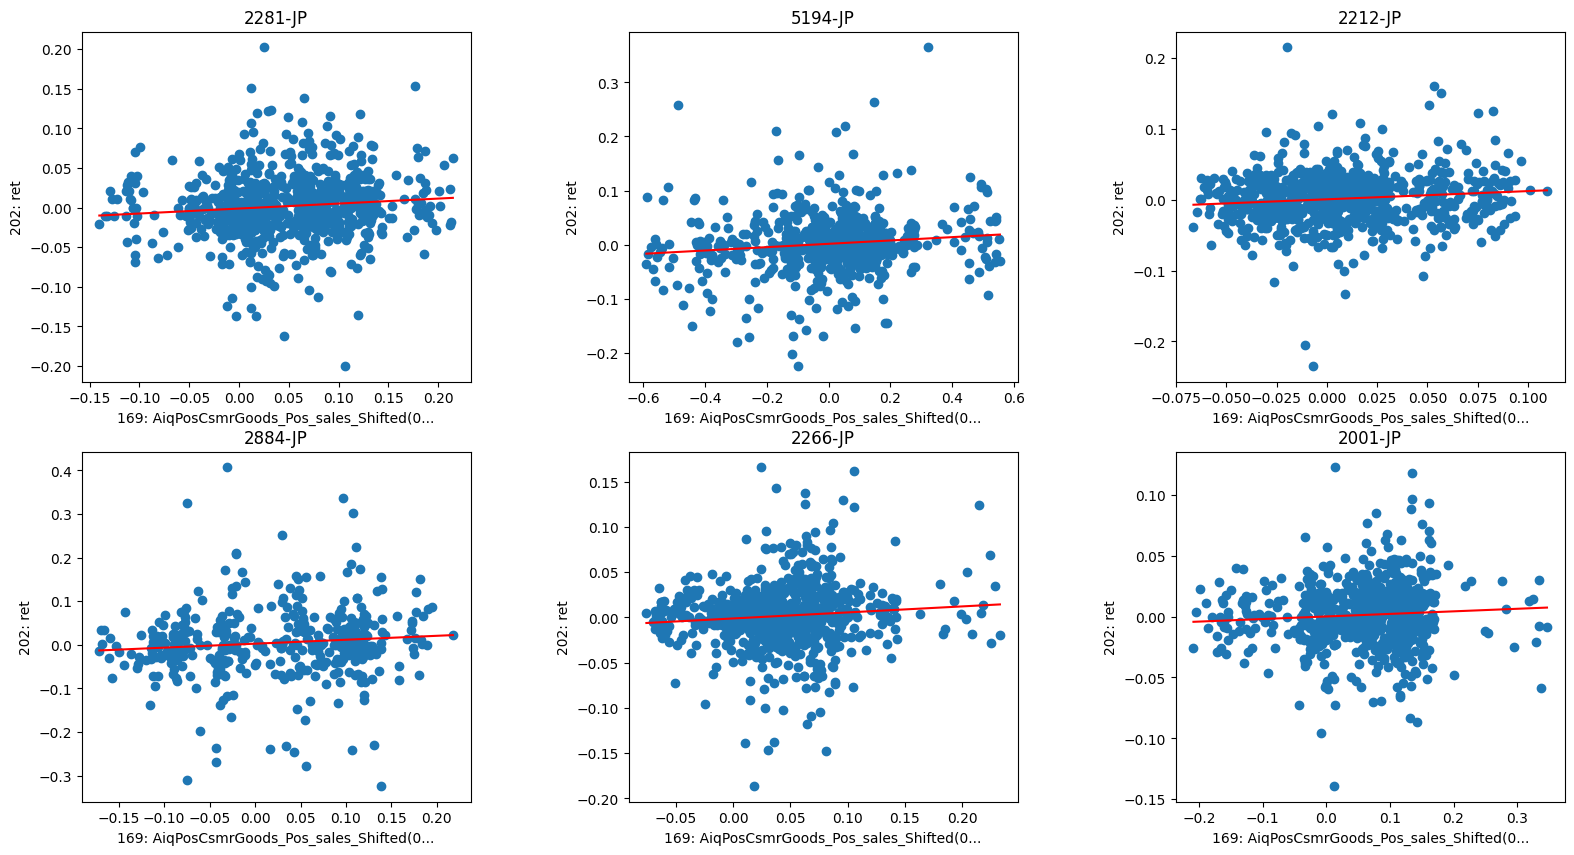

In [23]:
top6tickers = rho_time.T.xs('t-val', level=1).sort_values('pos_sales', ascending=False).index[:6]

sdh.show_scatter_per_target(
    y=close_ret,
    x=alt_W_shift_1_sma12_logdiff_ids[0],
    targets=top6tickers,
    col_num=3,
    vname_len_limit=35,
)

## バックテスト
> 株価変化率ともっとも相関の良い特徴量をシグナルにして、ポートフォリオ分析を実施します.

In [24]:
# define the parameters for factor choice.
nq = 3
exe_cost = 0.0005

# Use pre-created variable ID
pos_sales = alt_W_shift_1_sma12_logdiff_ids[0]
ret = close_ret

In [25]:
dfqret, stats, dfsigqt = ade.q_backtest(
    pos_sales,
    ret,
    nq=nq,
    exe_cost=exe_cost,
    plot=True,
    stats=True
)

cum.Ret   ann.Ret   ann.Std       R/R     Win_R  ann.TurnOver  \
#1           0.520426  0.035288  0.143565  0.245798  0.561769      2.753615   
#2           0.742365  0.050337  0.136019  0.370071  0.573472      5.173438   
#3           1.310755  0.088877  0.140243  0.633737  0.596879      2.702957   
#3-#1        0.790330  0.053589  0.049532  1.081913  0.592978      5.456571   
#3-#1(cost)  0.750145  0.050864  0.049534  1.026859  0.587776      5.456571   

               Max_DD  Calmar Ratio  
#1          -0.496438      0.071082  
#2          -0.390692      0.128840  
#3          -0.426742      0.208269  
#3-#1       -0.076768      0.698069  
#3-#1(cost) -0.078143      0.650914